In [374]:
import json
import numpy as np

json_file_path = '/Users/jamessmith/Desktop/Desktop/SemEval_Task/data/subtask1/train.json'

# Swap the file opening and data loading statements
with open(json_file_path, 'r', encoding='utf-8') as file:
    data = json.load(file)

labels = [sample.get("labels", []) for sample in data]

# lists to get all labels
all_labels = [label for sublist in labels for label in sublist]

num_unique_labels = len(set(all_labels))
print(f"Number of Unique Labels: {num_unique_labels}")
print("Label Names:", set(all_labels))

Number of Unique Labels: 20
Label Names: {'Slogans', "Misrepresentation of Someone's Position (Straw Man)", 'Exaggeration/Minimisation', 'Whataboutism', 'Name calling/Labeling', 'Causal Oversimplification', 'Doubt', 'Black-and-white Fallacy/Dictatorship', 'Appeal to fear/prejudice', 'Reductio ad hitlerum', 'Flag-waving', 'Bandwagon', 'Presenting Irrelevant Data (Red Herring)', 'Glittering generalities (Virtue)', 'Thought-terminating cliché', 'Appeal to authority', 'Smears', 'Loaded Language', 'Obfuscation, Intentional vagueness, Confusion', 'Repetition'}


In [395]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling1D
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_recall_fscore_support, classification_report

class MemeClassification:
    def __init__(self, label_tree):
        self.label_tree = label_tree
        self.label_binarizer = None
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.bert_model = TFBertModel.from_pretrained('bert-base-uncased')
        self.model = None

    def load_data(self, json_file_path):
        with open(json_file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)
        return data

    def preprocess_data(self, data):
        texts = [sample["text"] for sample in data]
        labels = [sample.get("labels", []) for sample in data]
        
        #checks if labels are empty and assign a default label 
        default_label = ['None']  
        labels = [label if label else default_label for label in labels]

        #converting labels to one hot encoded
        if any(isinstance(label, list) for label in labels):
            self.label_binarizer = MultiLabelBinarizer()
            y = self.label_binarizer.fit_transform(labels)
        else:
            y = np.array(labels)
        return texts, y

    def tokenize_and_pad(self, texts):
        input_ids = []
        attention_masks = []

        for text in texts:
            encoded_text = self.tokenizer(text, max_length=128, truncation=True, padding='max_length', return_tensors='tf')
            input_ids.append(encoded_text['input_ids'])
            attention_masks.append(encoded_text['attention_mask'])

        input_ids = np.concatenate(input_ids, axis=0)
        attention_masks = np.concatenate(attention_masks, axis=0)

        return input_ids, attention_masks

    def build_model(self, num_classes=21):
        input_ids_input = Input(shape=(128,), dtype=tf.int32, name="input_ids")
        attention_masks_input = Input(shape=(128,), dtype=tf.int32, name="attention_masks")

        bert_output = self.bert_model(input_ids_input, attention_mask=attention_masks_input)[0]
        pooled_output = GlobalAveragePooling1D()(bert_output)
        output_layer = Dense(num_classes, activation='sigmoid')(pooled_output)

        self.model = Model(inputs=[input_ids_input, attention_masks_input], outputs=output_layer)
        self.model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    def train_model(self, json_file_path, num_classes=21, epochs=3, batch_size=8, test_size=0.2, random_state=42):
        data = self.load_data(json_file_path)
        texts, y = self.preprocess_data(data)
        input_ids, attention_masks = self.tokenize_and_pad(texts)

        # Split the data
        X_train, X_temp, y_train, y_temp, attention_masks_train, attention_masks_temp = train_test_split(
            input_ids, y, attention_masks, test_size=test_size, random_state=random_state
        )

        X_val, X_test, y_val, y_test, attention_masks_val, attention_masks_test = train_test_split(
            X_temp, y_temp, attention_masks_temp, test_size=0.5, random_state=random_state
        )
        
        print("Shapes:")
        print("X_train:", X_train.shape)
        print("y_train:", y_train.shape)
        print("X_val:", X_val.shape)
        print("y_val:", y_val.shape)
        
        # Build and compile the model
        self.build_model(num_classes)
        
        # Train the model
        history = self.model.fit(
            [X_train, attention_masks_train],
            y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=([X_val, attention_masks_val], y_val),
        )
        
        return history, X_test, attention_masks_test, y_test
    
    def plot_training_history(self, history):
        plt.figure(figsize=(10, 4))
        
        #plot accuracy
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(['Train', 'Validation'], loc='upper left')

        #plot loss 
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(['Train', 'Validation'], loc='upper left')
        
        plt.tight_layout()
        plt.show()      


    def calculate_hierarchy_distance(self, node1, node2):
        # Check if the nodes are leaf nodes
        if node1 not in self.label_tree or node2 not in self.label_tree:
            return None

        # Find ancestors of each leaf node
        ancestors1 = set()
        current_node = node1
        while current_node:
            ancestors1.add(current_node)
            current_node = next((parent for parent, children in self.label_tree.items() if current_node in children), None)

        ancestors2 = set()
        current_node = node2
        while current_node:
            ancestors2.add(current_node)
            current_node = next((parent for parent, children in self.label_tree.items() if current_node in children), None)

        # Find common ancestors
        common_ancestors = ancestors1.intersection(ancestors2)

        # Distance based on levels
        distance = len(ancestors1) + len(ancestors2) - 2 * len(common_ancestors)

        return distance

    def evaluate_with_hierarchy(self, X_test, attention_masks_test, y_test):
        print("X_test:", X_test.shape)
        print("y_test:", y_test.shape)

        predictions = self.model.predict([X_test, attention_masks_test])

        total_precision = 0.0
        total_recall = 0.0
        total_samples = len(y_test)

        predicted_labels_all = []
        true_labels_all = []

        for i in range(total_samples):
            predicted_probabilities = predictions[i]

            #decoding predicted labels
            predicted_labels = [self.label_binarizer.classes_[j] for j in range(len(self.label_binarizer.classes_)) if
                                predicted_probabilities[j] > 0.5]
            gold_labels = [self.label_binarizer.classes_[j] for j in range(len(self.label_binarizer.classes_)) if
                           y_test[i][j] == 1]

            #predicted and true labels' lists
            predicted_labels_all.append(predicted_labels)
            true_labels_all.append(gold_labels)
            
            # Convert the lists to binary arrays
            mlb = MultiLabelBinarizer()
            true_labels_all_binary = mlb.fit_transform(true_labels_all)
            predicted_labels_all_binary = mlb.transform(predicted_labels_all)
            
        ##calculation of the hierarchical_f1

            #checks if the prediction is a leaf node and is the correct label
            if set(predicted_labels).issubset(set(gold_labels)):
                reward = 1.0  # Full reward
            elif any(
                    self.calculate_hierarchy_distance(predicted_label, gold_label) > 0 for predicted_label in
                    predicted_labels for gold_label in gold_labels):
                reward = 0.5  # Partial reward
            else:
                reward = 0.0  # Null reward

            #total_precision andtotal_recall on reward
            total_precision += reward
            total_recall += reward

        #average metrics
        average_precision = total_precision / total_samples
        average_recall = total_recall / total_samples

        #hierarchical F1
        hierarchical_f1 = 2 * (average_precision * average_recall) / (average_precision + average_recall) if (
                average_precision + average_recall) != 0 else 0.0
    
        print("Classification Report:")
        print(classification_report(true_labels_all_binary, predicted_labels_all_binary, target_names=mlb.classes_))  # Update target_names

        return hierarchical_f1, predicted_labels_all, true_labels_all

#hierarchical tree
#the assigned number are hypothetically
label_tree = {
    'Persuasion': {
        'Pathos': {
            'Appeal to Emotion(visual)': 1,
            'Exaggeration/Minimisation': 2,
            'Loaded Language': 3,
            'Flag waving': 4,
            'Appeal to fear/prejudice': 5,
            'Transfer': 6
        },
        'Ethos': {
            'Transfer': 6,
            'Glittering generalities': 7,
            'Appeal to authority': 8,
            'Bandwagon': 9,
            'Ad Hominem': {
                'Name calling/Labelling': 10,
                'Doubt': 11,
                'Smears': 12,
                'Reduction and Hitlerium': 13,
                'Whataboutism': 14
            }
        },
        'Logos': {
            'Repetition': 15,
            'Obfuscation, Intentional vagueness, Confusion': 16,
            'Justification': {
                'Flag waving': 4,
                'Appeal to fear/prejudice': 5,
                'Appeal to Authority': 8,
                'Bandwagon': 9,
                'Slogans': 17
            },
            'Reasoning': {
                'Distraction': {
                    'Whataboutism': 14,
                    'Presenting Irrelevant Data (Red Herring)': 18,
                    'Straw Man': 19
                },
                'Simplification': {
                    'Black-and-white Fallacy/Dictatorship': 20,
                    'Casual Oversimplification': 21,
                    'Thought-terminating cliché': 22
                }
            }
        },
        'None': 23 # a label for empty samples
    }
}

json_file_path = '/Users/jamessmith/Desktop/Desktop/SemEval_Task/data/subtask1/train.json'

meme_classifier = MemeClassification(label_tree)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [396]:
data = meme_classifier.load_data(json_file_path)
print("Loaded Data:", data[:1])

Loaded Data: [{'id': '65635', 'text': 'THIS IS WHY YOU NEED\\n\\nA SHARPIE WITH YOU AT ALL TIMES', 'labels': ['Black-and-white Fallacy/Dictatorship'], 'link': 'https://www.facebook.com/photo/?fbid=4023552137722493&set=g.633131750534436'}]


In [397]:
texts, y = meme_classifier.preprocess_data(data)
print("Processed Texts:", texts[:1]) 
print("Processed Labels:", y[:1])  

Processed Texts: ['THIS IS WHY YOU NEED\\n\\nA SHARPIE WITH YOU AT ALL TIMES']
Processed Labels: [[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [398]:
# Tokenize and pad
input_ids, attention_masks = meme_classifier.tokenize_and_pad(texts)
print("Tokenized Input IDs:", input_ids.shape)  
print("Attention Masks:", attention_masks.shape)
# Display a few examples
num_examples = 3
for i in range(num_examples): 
    print(f"Example {i + 1}:")
    print("Tokenized Input IDs:", input_ids[i])
    print("Attention Masks:", attention_masks[i])
    print("\n")

Tokenized Input IDs: (7000, 128)
Attention Masks: (7000, 128)
Example 1:
Tokenized Input IDs: [ 101 2023 2003 2339 2017 2342 1032 1050 1032 6583 4629 2666 2007 2017
 2012 2035 2335  102    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
Attention Masks: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 

In [399]:
#train the model
history, X_test, attention_masks_test, y_test = meme_classifier.train_model(json_file_path)


Shapes:
X_train: (5600, 128)
y_train: (5600, 21)
X_val: (700, 128)
y_val: (700, 21)
Epoch 1/3
700/700 [==============================] - 2012s 3s/step - loss: 0.2678 - accuracy: 0.1107 - val_loss: 0.2648 - val_accuracy: 0.1800
Epoch 2/3
700/700 [==============================] - 2209s 3s/step - loss: 0.2579 - accuracy: 0.1150 - val_loss: 0.2659 - val_accuracy: 0.0943
Epoch 3/3
700/700 [==============================] - 2178s 3s/step - loss: 0.2546 - accuracy: 0.1302 - val_loss: 0.2915 - val_accuracy: 0.1800


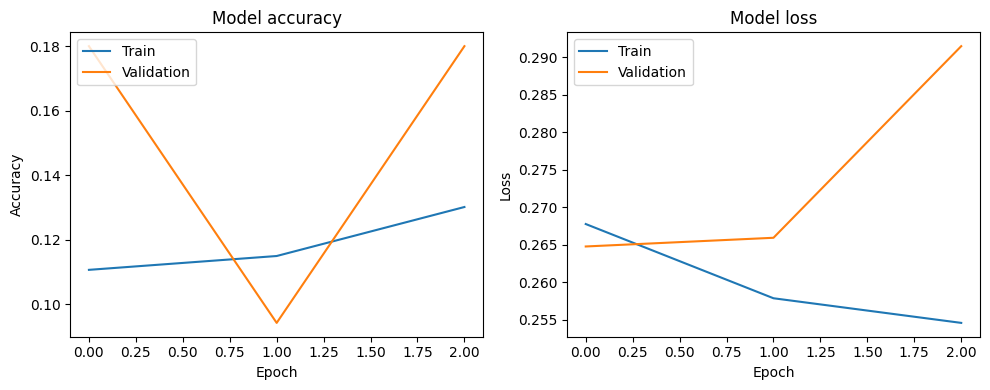

In [400]:
#plot the training history
meme_classifier.plot_training_history(history)

In [401]:
# Assuming you have already trained the model and obtained X_test, attention_masks_test, y_test
hierarchical_f1, predicted_labels_all, true_labels_all = meme_classifier.evaluate_with_hierarchy(X_test, attention_masks_test, y_test)
print(f"Average Hierarchical F1: {hierarchical_f1}")


X_test: (700, 128)
y_test: (700, 21)
22/22 [==============================] - 74s 3s/step


/Users/jamessmith/Desktop/Desktop/python/miniconda3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['None'] will be ignored
  warnings.warn(


TypeError: '>' not supported between instances of 'NoneType' and 'int'

In [402]:

#DataFrame for predicted_labels and true_labels
comparison_df = pd.DataFrame({'True Labels': true_labels_all, 'Predicted Labels': predicted_labels_all})
print(comparison_df.head(20))

NameError: name 'true_labels_all' is not defined